In [1]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain_classic langchain-core langchain-openai langchain-community langchain langchain-chroma chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25 weaviate-client ragas wikipedia langchain-weaviate langchain-together langchain-experimental tiktoken langgraph langchain-tavily

# Install compatible versions of langchain-core and langchain-openai
%pip install langchain-community==0.4.1
%pip install langchain-text-splitters==1.0.0
%pip install langchain-openai==1.1.0
%pip install langsmith==0.4.49
%pip install langchain==1.1.0

# Install remaining packages
%pip install langchain-chroma==1.0.0
%pip install chromadb==1.3.5
%pip install python-dotenv==1.2.1
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2
%pip install langchain-classic==1.0.0
%pip install langchain_core==1.1.3

# new agent-related installs
%pip install tiktoken==0.12.0
%pip install langgraph==1.0.4
%pip install langchain-tavily==0.2.13

Note: you may need to restart the kernel to use updated packages.
Found existing installation: langchain-classic 1.0.0
Uninstalling langchain-classic-1.0.0:
  Successfully uninstalled langchain-classic-1.0.0
Found existing installation: langchain-core 1.1.3
Uninstalling langchain-core-1.1.3:
  Successfully uninstalled langchain-core-1.1.3
Found existing installation: langchain-openai 1.1.0
Uninstalling langchain-openai-1.1.0:
  Successfully uninstalled langchain-openai-1.1.0
Found existing installation: langchain-community 0.4.1
Uninstalling langchain-community-0.4.1:
  Successfully uninstalled langchain-community-0.4.1
Found existing installation: langchain 1.1.0
Uninstalling langchain-1.1.0:
  Successfully uninstalled langchain-1.1.0
Found existing installation: langchain-chroma 1.0.0
Uninstalling langchain-chroma-1.0.0:
  Successfully uninstalled langchain-chroma-1.0.0
Found existing installation: chromadb 1.3.5
Uninstalling chromadb-1.3.5:
  Successfully uninstalled chromadb-1.3.5


In [1]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_chroma import Chroma
import chromadb
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain_core.documents import Document
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# variables
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)
agent_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)
embedding_function = OpenAIEmbeddings()
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [ ]:
#### INDEXING ####

In [3]:
# Load the PDF and extract text
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [4]:
# Split
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [5]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [6]:
# Chroma Vector Store
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [7]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [ ]:
#### TOOLS ####

In [ ]:
# Tool #1: Web Search

In [8]:
# Tavily Setup
# set up your API key at https://tavily.com/
# add the API key to your env.txt file
from langchain_tavily import TavilySearch

_ = load_dotenv(dotenv_path='env.txt')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
web_search = TavilySearch(max_results=4)
web_search_name = web_search.name

In [9]:
web_search.invoke(user_query)

{'query': "What are Google's environmental initiatives?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.google/outreach-initiatives/sustainability/2024-environmental-report/',
   'title': 'Our 2024 Environmental Report - Google Blog',
   'content': 'Our annual Environmental Report offers a deep dive into our efforts to harness technology — particularly AI — to drive positive environmental change and operate our business sustainably. 1  We’ve also identified tested practices that our research shows can, when used together, reduce the energy required to train an AI model by up to 100 times and reduce associated emissions by up to 1,000 times. A Google-owned and -operated data center is, on average, approximately 1.8 times as energy efficient as a typical enterprise data center. In 2017, Google became the first major company to match 100% of our annual electricity consumption on a global basis with renewable energy, which we’ve achieved e

In [ ]:
# Tool #2: Data Retriever

In [13]:
from langchain_core.tools import create_retriever_tool

retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "retrieve_google_environmental_question_answers",
    "Extensive information about Google environmental efforts from 2023.",
)
retriever_tool_name = retriever_tool.name

In [14]:
# Define tools for agent
tools = [web_search, retriever_tool]

In [15]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [17]:
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition

In [18]:
generation_prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer 
    the question. If you don't know the answer, just say 
    that you don't know. Provide a thorough description to 
    fully answer the question, utilizing any relevant 
    information you find.
    
    Question: {question} 
    Context: {context} 
    
    Answer:"""
)

In [19]:
### Edges - determines whether the retrieved documents are relevant to the question.
def score_documents(state) -> Literal["generate", "improve"]:

    print("---CHECK RELEVANCE---")

    # Data model - returns a binary score for the relevance check
    class scoring(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(scoring)

    # Prompt
    prompt = PromptTemplate(
        template="""
        You are assessing relevance of a retrieved document to a user question with a binary grade. \n 
        
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "improve"

In [ ]:
### Nodes

In [20]:
# Agent node - invokes the agent model to generate a response based on the current state. 
# Decision choices (given the question): retrieve using the retriever tool, web_search tool, both, or end.
def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = agent_llm.bind_tools(tools)
    response = llm.invoke(messages)
    return {"messages": [response]} # Return list, will get added to existing list

In [21]:
# Improve node - transform the query to produce a better question.
def improve(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(content=f"""\n 
            Look at the input and try to reason about the underlying semantic intent / meaning. \n 
            Here is the initial question:
            \n ------- \n
            {question} 
            \n ------- \n
            Formulate an improved question: 
            """,
        )
    ]

    # Scoring
    response = llm.invoke(msg)
    return {"messages": [response]}

In [22]:
# Generate node - generate answer
def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Chain
    rag_chain = generation_prompt | llm | str_output_parser

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [23]:
# Cyclical Graph Setup
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval from web and or retriever
workflow.add_node("improve", improve)  # Improving the question for better retrieval
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve (assess agent decision)
workflow.add_conditional_edges("agent", tools_condition, 
    # Translate the condition outputs to nodes in our graph
    {
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called (assess agent decision)
workflow.add_conditional_edges("retrieve", score_documents)
workflow.add_edge("generate", END)
workflow.add_edge("improve", "agent")

# Compile
graph = workflow.compile()

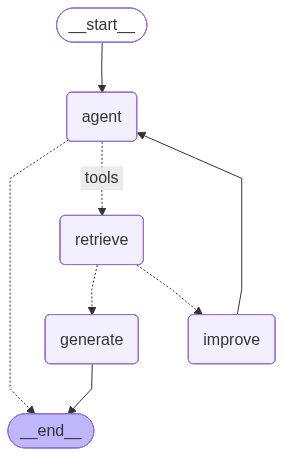

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [25]:
import pprint

inputs = {
    "messages": [
        ("user", user_query),
    ]
}
final_answer = ''
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
        final_answer = value
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--019b0ae8-41da-7602-951c-ea7ace24d3f4', tool_calls=[{'name': 'retrieve_google_environmental_question_answers', 'args': {'query': 'Google environmental initiatives'}, 'id': 'call_NmtwRac6DLoxhq3nqeDqG7Wo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1312, 'output_tokens': 20, 'total_tokens': 1332, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Protection Agency (EPA), including 3 Google hosted events with EPA Administrator Michael \nRegan on environmental justice, how Google pro

In [26]:
final_answer['messages'][0]

"Google has a comprehensive set of environmental initiatives aimed at promoting sustainability and addressing climate change. These initiatives are organized around several key areas:\n\n1. **Sustainable Operations**: Google is committed to operating sustainably by achieving net-zero carbon emissions and advancing carbon-free energy. They focus on energy-efficient and low-carbon facilities, particularly in their data centers, and have integrated environmental considerations into their strategic planning.\n\n2. **Product and Technology Innovations**: Google aims to empower individuals to make sustainable choices through their products. For example, they offer eco-friendly routing in Google Maps, energy efficiency features in Google Nest thermostats, and carbon emissions information in Google Flights. Their goal is to help reduce 1 gigaton of carbon equivalent emissions annually by 2030.\n\n3. **Circular Economy and Recycling**: Google promotes recycling and the circular economy through 

*Formatted:*

Google has a comprehensive and multifaceted approach to environmental sustainability, encompassing various initiatives aimed at reducing carbon emissions, promoting sustainable practices, and leveraging technology for environmental benefits. Here are some key aspects of Google's environmental initiatives:

1. **Carbon Reduction and Renewable Energy**:  
- **iMasons Climate Accord**: Google is a founding member and part of the governing body of this coalition focused on reducing carbon emissions in digital infrastructure.
- **Net-Zero Carbon**: Google is committed to operating sustainably with a focus on achieving net-zero carbon emissions. This includes investments in carbon-free energy and energy-efficient facilities, such as their all-electric, net water-positive Bay View campus.

2. **Sustainable Consumption and Circular Economy**:
- **Right to Repair**: Google has engaged with the European Commission to promote the repair and reuse of goods, particularly smartphones and tablets.
- **Circular Economy**: Google works with suppliers to ensure environmental criteria are met, including the management of hazardous substances and resource efficiency. They also promote recycling and the use of refurbished products.

3. **Water Stewardship**:
- Google supports watershed projects and responsible water use, including initiatives in Chile and the United States. Their Bay View campus incorporates stormwater retention and other water-positive features.

4. **Food Waste Reduction**:
- **ReFED**: Google provided anchor funding to the ReFED Catalytic Grant Fund to accelerate and scale food waste solutions.

5. **Reforestation and Biodiversity**:
- **The Nature Conservancy (TNC)**: Google supports reforestation projects and the development of technology to stop deforestation in the Amazon. They also work on kelp reforestation and other biodiversity initiatives.

6. **Technology and Data for Environmental Action**:
- **Google Earth Engine**: Provides access to data for monitoring environmental changes.
- **Environmental Insights Explorer**: Helps cities and organizations measure and reduce their carbon footprint.
- **Google Maps Eco-Friendly Routing**: Offers routes that reduce carbon emissions, helping users make more sustainable travel choices.

7. **Public Policy and Advocacy**:
- Google engages in public policy advocacy to support clean energy and climate action, including comments on the U.S. Department of Energy's Clean Hydrogen Production Standard and participation in the First Movers Coalition for carbon dioxide removal.

8. **Partnerships and Coalitions**:
- Google collaborates with various organizations, including the World Business Council for Sustainable Development (WBCSD) and the World Resources Institute (WRI), to promote sustainability and address climate change.

9. **Empowering Individuals and Communities**:
- Google aims to help 1 billion people make more sustainable choices through their products by 2030. This includes features like energy-efficient Google Nest thermostats and carbon emissions information in Google Flights.

Overall, Google's environmental initiatives are extensive and integrated into their business operations, product development, and community engagement, reflecting their commitment to sustainability and climate action.